In [2]:
import os, sys, glob, sqlite3, json, collections
import numpy as np
import pandas as pd
sys.path.insert(1, '../src')

db = sqlite3.connect('../db_preprocessed.sqlite')
db.row_factory = lambda x,y: dict(sqlite3.Row(x,y))
def query_db(q, p=[]):
    return db.cursor().execute(q, p).fetchall()
db.cursor().executescript(open('../src/db_init.sql').read())
db.commit()
cur = db.cursor()

# Oracle

In [21]:
user = 'sample-A-benno-clusters:benno'
cols = query_db("""
    SELECT t.headerId, at.clusterId, ac.col, ac.clustercol, COUNT(DISTINCT (t.pgId||'-'||t.tbNr)) AS nTables
    FROM annotation_columns AS ac
    JOIN tables AS t ON (ac.pgId=t.pgId) AND (ac.tbNr=t.tbNr)
    JOIN annotation_tables AS at ON (ac.user = at.user) AND (ac.pgId=at.pgId) AND (ac.tbNr=at.tbNr)
    WHERE (ac.user = :user) AND (ac.clustercol is not NULL)
    GROUP BY t.headerId, at.clusterId, ac.col, ac.clustercol
""", {'user':user})
df = pd.DataFrame(cols)
df = df[df['nTables'] == df.groupby(['headerId', 'clusterId', 'col', 'clustercol'])['nTables'].transform('max')]
# df.to_csv('../output/sample-A-headerunions/benno-alignments.tsv', index=None, sep='\t')
df.sort_values('nTables', ascending=False)

headerId  clusterId  col  clustercol  nTables
443   1111143432686705088    1300523    1           1       41
442   1111143432686705088    1300523    0           0       41
740   1657868244709389437    1520409    2           3       41
739   1657868244709389437    1520409    1           2       41
738   1657868244709389437    1520409    0           1       41
...                   ...        ...  ...         ...      ...
1323  3066049205316036716     897545    2           2        1
1324  3066049205316036716     897545    3           3        1
1325  3066049205316036716     897545    4           4        1
1326  3066049205316036716     897545    5           5        1
3870  9220351431536037132    1529503    8           8        1

[3871 rows x 5 columns]

In [157]:
# Get annotation unpivots
from db_load import TSVWriter
user = 'sample-A-benno-clusters:benno'

pivots = query_db("""
    SELECT *
    FROM annotation_pivots AS ap
    WHERE (ap.user = :user) AND (ap.level != -1)
""", {'user':user})
print(len(pivots))
print(pivots[:1])

fname = '../output/sample-A-headerunions/benno-pivots.tsv'
w = TSVWriter('pivots', fname)
for p in pivots:
    w.writerow(p)
w.fw.flush()
w.fw.close()
    
!head $fname

137
[{'user': 'sample-A-benno-clusters:benno', 'headerId': 624485190924261, 'level': 0, 'colFrom': 1, 'colTo': 11, 'pivotedHeaderId': 6481933304312819270, 'heuristic': None, 'score': None}]
624485190924261	0	1	11	6481933304312819270			
21581017318800208	0	1	8	5932104590410045238			
67629378360308841	0	5	10	1742232926541664498			
98712500576535578	1	2	2	1339204068720534672			
124842056656842358	0	1	12	8802068660557479263			
367395442955457106	0	2	5	2007095492069816197			
375920919041214924	0	2	9	6152967802872892487			
376360699898625374	0	1	12	2641216804379333053			
472350334703855636	0	1	15	6470463657926150422			
572779403186517847	1	2	6	7037821711219142560			


In [133]:
# Get tables of headers of sample
user = 'sample-A-benno-clusters:benno'

tables = db.cursor().execute("""
    SELECT t2.*
    FROM annotation_tables AS at
    JOIN tables AS t1 ON (at.pgId=t1.pgId) AND (at.tbNr=t1.tbNr)
    JOIN tables AS t2 ON (t1.headerId = t2.headerId)
    WHERE (at.user = :user)
""", {'user':user})

tableids = set()
for ip, t in enumerate(tables):
    tableids.add( (t['pgId'], t['tbNr']) )
    if not ip % 100:
        print(f'Got {ip:9d}', end='\r')
print(f'Got {ip:9d}')

with open('../output/sample-A-headerunions/tableids.tsv', 'w') as fw:
    for pgId, tbNr in tableids:
        print(pgId, tbNr, sep='\t', file=fw)

Got   8538895


# Matcher speeds

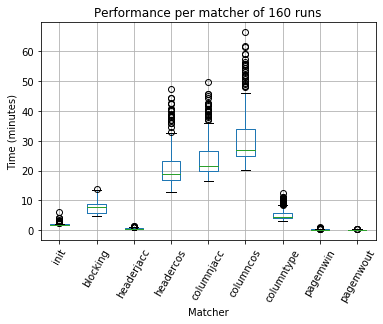

In [17]:
%matplotlib inline
# simlog = !cat ../output/sample-A+100k/10jan-headerunions/similarity-log/*
simlog = !cat ../output/all/11jan/similarity-log/*
simlog = [json.loads(line) for line in simlog]
df = pd.DataFrame(simlog)/60
ax = df.boxplot(rot=60)
ax.set(title=f'Performance per matcher of {len(simlog)} runs', ylabel='Time (minutes)', xlabel='Matcher')
None

# DB edits

In [113]:
tablename = 'annotation_tables'
names = ' '.join(schemas[tablename]).replace('user ', '') + ' user'
r = cur.execute(f"DROP TABLE IF EXISTS {tablename}");
db.cursor().executescript(open('db_init.sql').read())
db.commit()
from db_init import get_schemas
schemas = get_schemas()
import pandas
df = pandas.read_csv(f'db/{tablename}.csv', names=names.split())
df.head()

pgId  tbNr  clusterId   user
0  14554576     1          1  benno
1  20851901     1          2  benno
2  24274181     1          3  benno
3  15429590     1          4  benno
4    276469     1       1002  benno

In [124]:
%%time
# df.to_sql(tablename, db, if_exists='append', index=False)
cur.execute(f"""
""", [])
db.commit()
r = cur.execute(f"""
SELECT *
FROM annotation_clusters WHERE user != "benno" --{tablename}
""", []).fetchall()
print(len(r))
for x in r[:10]:
    print(x)

708
{'user': '16aug-1', 'clusterId': 680, 'keycol': None}
{'user': '16aug-1', 'clusterId': 69, 'keycol': None}
{'user': '16aug-1', 'clusterId': 95, 'keycol': None}
{'user': '16aug-1', 'clusterId': 194711, 'keycol': None}
{'user': '16aug-1', 'clusterId': 108, 'keycol': None}
{'user': '16aug-1', 'clusterId': 146, 'keycol': None}
{'user': '16aug-1', 'clusterId': 206, 'keycol': None}
{'user': '16aug-1', 'clusterId': 210, 'keycol': None}
{'user': '16aug-1', 'clusterId': 238, 'keycol': None}
{'user': '16aug-1', 'clusterId': 202525, 'keycol': None}
CPU times: user 7.93 ms, sys: 0 ns, total: 7.93 ms
Wall time: 6.87 ms


In [12]:
r = cur.execute(f"""

""", [])
for i,h in enumerate(cur):
    if not i % 10**6: print(i)

KeyboardInterrupt: 

# Remove column from db table

In [18]:
%%time
# Copy script
tablename = 'headers'
schema = """
headerId INTEGER
row INTEGER
col INTEGER
cellText TEXT
colspan INTEGER
repeats INTEGER
""".strip().replace('\t', ' ').split('\n')
selection = ', '.join(s.split()[0] for s in schema)
schema = ', '.join(schema)

r = cur.executescript(f"""
DROP TABLE IF EXISTS backup;
CREATE TEMPORARY TABLE backup({schema});
INSERT INTO backup SELECT {selection} FROM {tablename};
""")
db.commit()
print(cur.execute("SELECT COUNT(*) FROM backup").fetchone())
r = cur.execute("SELECT * FROM backup LIMIT 10").fetchall()
for x in r:
    print(x)

{'headerId': 74385146558770, 'row': 0, 'col': 0, 'cellText': 'precededby fanuel kozonguizi', 'colspan': 1, 'repeats': 1}
{'headerId': 74385146558770, 'row': 0, 'col': 1, 'cellText': 'chairman of the transitional government of national unity of namibia june–september 1986', 'colspan': 1, 'repeats': 1}
{'headerId': 74385146558770, 'row': 0, 'col': 2, 'cellText': 'succeededby dirk mudge', 'colspan': 1, 'repeats': 1}
{'headerId': 89132520176970, 'row': 0, 'col': 0, 'cellText': 'athlete', 'colspan': 1, 'repeats': 1}
{'headerId': 89132520176970, 'row': 0, 'col': 1, 'cellText': 'years active', 'colspan': 1, 'repeats': 1}
{'headerId': 89132520176970, 'row': 0, 'col': 2, 'cellText': 'team(s)', 'colspan': 1, 'repeats': 1}
{'headerId': 171478065029390, 'row': 0, 'col': 0, 'cellText': 'actor', 'colspan': 1, 'repeats': 1}
{'headerId': 171478065029390, 'row': 0, 'col': 1, 'cellText': 'character', 'colspan': 1, 'repeats': 1}
{'headerId': 171478065029390, 'row': 0, 'col': 2, 'cellText': '1st episode',

In [19]:
r = cur.execute(f"DROP TABLE IF EXISTS {tablename}");
db.cursor().executescript(open('db_init.sql').read())
db.commit()

In [24]:
r = cur.executescript(f"INSERT INTO {tablename}({selection}) SELECT {selection} FROM backup")
db.commit()
print(cur.execute(f"SELECT COUNT(*) FROM {tablename}").fetchone())
r = cur.execute(f"SELECT * FROM {tablename} LIMIT 10").fetchall()
for x in r[:10]:
    print(x)

{'COUNT(*)': 4527036}
{'headerId': 74385146558770, 'row': 0, 'col': 0, 'cellText': 'precededby fanuel kozonguizi', 'colspan': 1, 'repeats': 1}
{'headerId': 74385146558770, 'row': 0, 'col': 1, 'cellText': 'chairman of the transitional government of national unity of namibia june–september 1986', 'colspan': 1, 'repeats': 1}
{'headerId': 74385146558770, 'row': 0, 'col': 2, 'cellText': 'succeededby dirk mudge', 'colspan': 1, 'repeats': 1}
{'headerId': 89132520176970, 'row': 0, 'col': 0, 'cellText': 'athlete', 'colspan': 1, 'repeats': 1}
{'headerId': 89132520176970, 'row': 0, 'col': 1, 'cellText': 'years active', 'colspan': 1, 'repeats': 1}
{'headerId': 89132520176970, 'row': 0, 'col': 2, 'cellText': 'team(s)', 'colspan': 1, 'repeats': 1}
{'headerId': 171478065029390, 'row': 0, 'col': 0, 'cellText': 'actor', 'colspan': 1, 'repeats': 1}
{'headerId': 171478065029390, 'row': 0, 'col': 1, 'cellText': 'character', 'colspan': 1, 'repeats': 1}
{'headerId': 171478065029390, 'row': 0, 'col': 2, 'cel

In [ ]:
# output = '\n'.join(output)
# from IPython.display import display
# display({'text/markdown': output}, raw=True)